*Unit 4, Sprint 3, Module 4*

---

# Time Series Forecasting using LSTMs 

## Objective 

- Students will understand how to prepare time series data for model ingestion (sliding train-test split) 
- Students will understand how to use a LSTM model for time series forecasting applications
- Students will understand the importance of seasonality and trends in time series applications.


### Applications of Time Series Forecasting 

![](https://miro.medium.com/max/2668/1*s7P8zInIavYbevpZg_iPaA.jpeg)


----
## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import time #helper libraries
import math


----
## 1. Load Data
We'll work with a time series of energy usage and weather data from kaggle.
- Using the "Download" button at the top right of [this page](https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries), save the data zip archive file to the Downloads folder in your local machine.

- Upload the zip archive to your Colab notebook, by first clicking the file folder icon on the left sidebar of this notebook, then clicking the "file upload" icon (file folder in portrait mode with upward arrow) on the upper left, below "Files", then selecting the zip archive, which is in your Downloads folder.

- Extract the `.csv` files from the zip archive. 

In [2]:
!unzip /content/pwer_usage_2016_to_2020.zip 

Archive:  /content/pwer_usage_2016_to_2020.zip
  inflating: power_usage_2016_to_2020.csv  
  inflating: weather_2016_2020_daily.csv  


In [3]:
def load_transform_data(weather_filepath, energy_filepath):
    """
    Load energy and weather data sets for energy consumption over a 4 year period for a single household in Austin, Texas. 
    Perform transformations in order to get data into a format that we can more easily use for LSTM modeling.
    
    Notes
    -----
    Links to source of data:
    https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries?select=weather_2016_2020_daily.csv
    
    Parameters 
    ------
    None
    
    Returns
    -------
    df: pandas dataframe
        Contains both the energy and weather feature sets 
    """
    # load the energy data
    df_energy = pd.read_csv(energy_filepath, parse_dates=['StartDate'], index_col='StartDate')
    df_energy_day = df_energy.resample('D').sum()

    # # load the weather data
    df_weather = pd.read_csv(weather_filepath, parse_dates=['Date'], index_col='Date')

    # merge the two dataframes
    df = pd.merge(df_energy_day, df_weather, left_index=True, right_index=True)

    # cleanup
    df = df.drop(columns=['day_of_week_x', 'Day'])

    # rename column
    df = df.rename(columns={'Value (kWh)': 'kwh'})

    # truncate the dates (trim early and late dates)
    # to drop data that's only weekly
    df = df.loc["2016-06-01": '2020-01-01']

    return df

df = load_transform_data("weather_2016_2020_daily.csv", "power_usage_2016_to_2020.csv")

df.head()

,kwh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week_y
2016-06-06,29.323,87,76.6,70,73,70.8,68,100,84.0,53,8,4.7,0,29.7,29.7,29.6,0.44,0
2016-06-07,43.361,95,87.0,82,79,74.4,69,89,67.6,44,15,9.9,6,29.9,29.9,29.8,0.00,1
2016-06-08,55.993,97,87.6,78,76,72.8,65,90,64.1,36,16,5.8,0,29.9,29.8,29.8,0.00,2
2016-06-09,39.040,92,83.2,75,76,73.8,70,97,75.0,48,16,7.0,0,30.0,30.0,29.9,0.02,3
2016-06-10,33.993,89,80.2,74,75,73.2,69,97,80.7,55,16,8.1,0,29.8,29.8,29.8,0.00,4


In [ ]:
df.tail()

,kwh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week_y
2019-12-28,5.200,77,69.6,63,68,65.0,61,97,85.9,66,22,10.1,3,29.8,29.7,29.6,0.00,5
2019-12-29,5.309,69,60.8,50,66,51.8,36,97,75.6,33,21,9.9,3,29.9,29.7,29.6,0.12,6
2019-12-30,4.947,61,50.3,39,37,31.0,26,89,51.8,26,10,5.7,0,30.1,30.0,29.9,0.71,0
2019-12-31,5.042,60,48.8,38,39,31.3,22,77,55.3,23,13,2.7,0,30.2,30.1,30.0,0.00,1
2020-01-01,4.814,60,55.0,48,58,46.3,35,93,73.8,47,18,7.3,0,30.0,29.8,29.7,0.00,2


----
## 2. Explore data -- examine seasonal trends

####Daily kwh usage time series

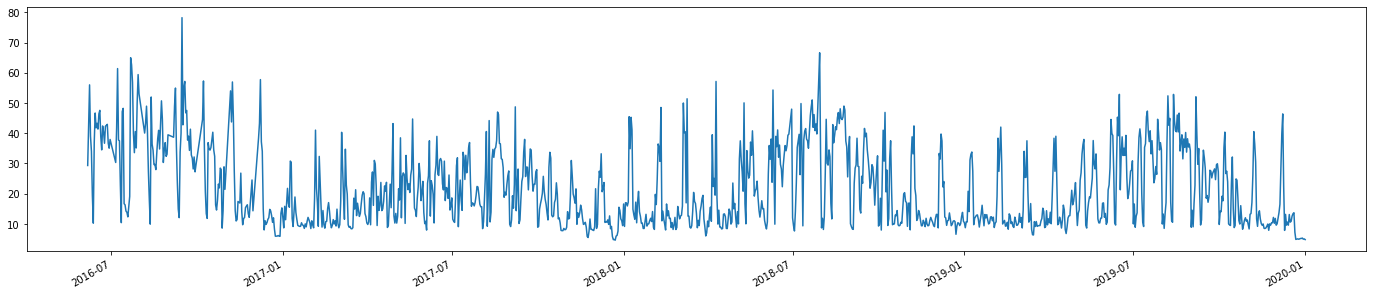

In [4]:
df.kwh.plot(figsize=(24,5));

####Daily Temperatures

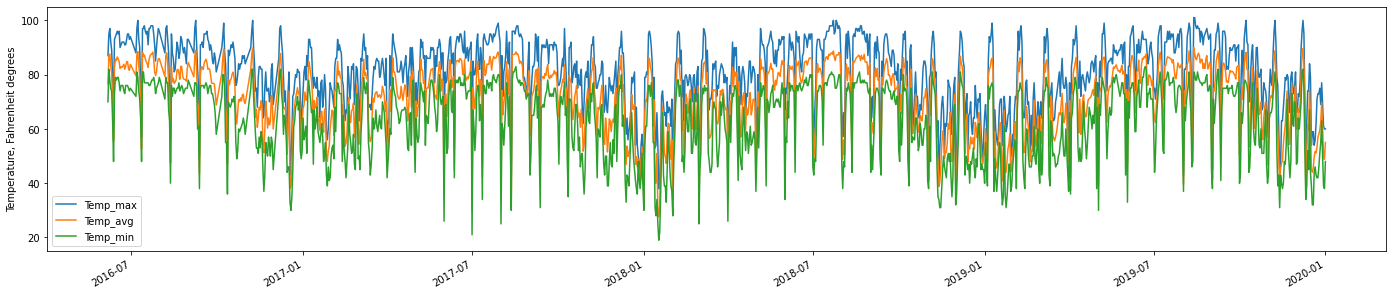

In [ ]:
plot_cols = ["Temp_max", 'Temp_avg', 'Temp_min']
df[plot_cols].plot(figsize=(24,5))
plt.ylabel('Temperature, Fahrenheit degrees');

####Resample temperature data to monthly intervals

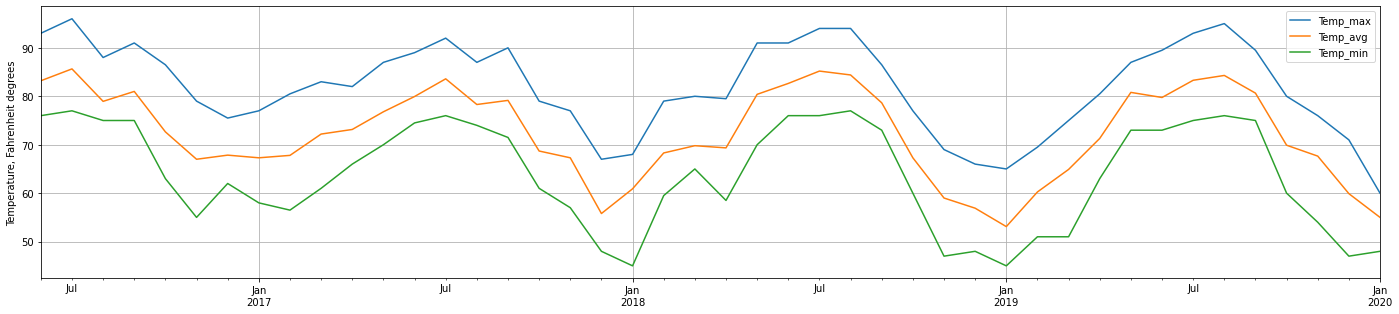

In [ ]:
df[plot_cols].resample('M').median().plot(figsize=(24,5))
plt.ylabel('Temperature, Fahrenheit degrees')
plt.grid()

#### Power consumption by day of week

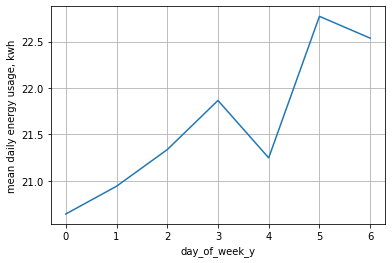

In [ ]:
df.groupby(['day_of_week_y'])['kwh'].mean().plot()
plt.ylabel('mean daily energy usage, kwh')
plt.grid()

### Mean daily kwh consumption, by month

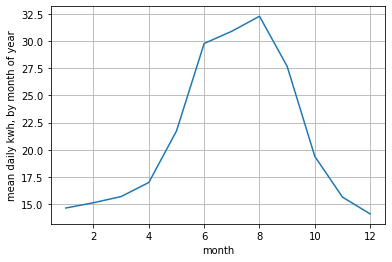

In [ ]:
# capture monthly seasonality
df['month'] = df.index.month
df.groupby(['month'])['kwh'].mean().plot()
plt.ylabel('mean daily kwh, by month of year')
plt.grid()

### Mean Daily kwh usage by week of year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


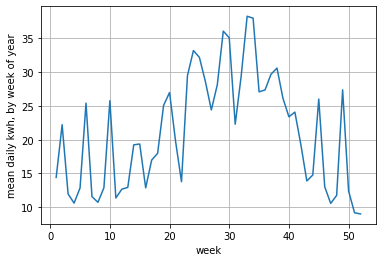

In [ ]:
# capture weekly seasonality
df['week'] = df.index.week
df.groupby(['week'])['kwh'].mean().plot()
plt.ylabel('mean daily kwh, by week of year');
plt.grid()

----
##3. Feature Selection
Identify features that are most strongly correlated with energy usage

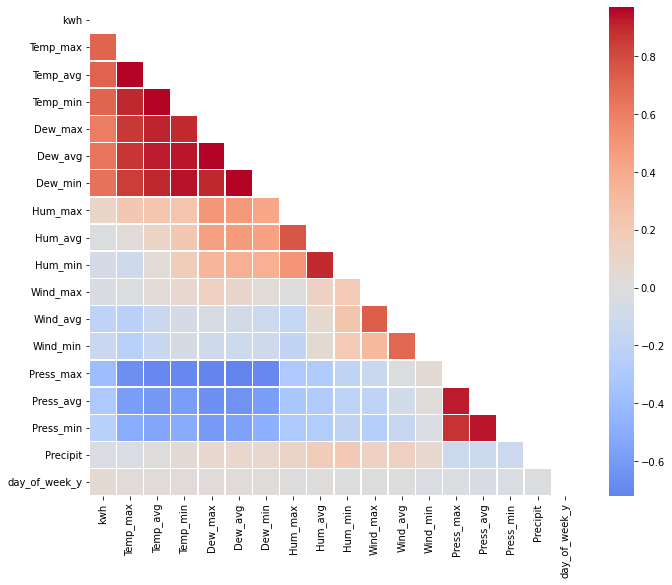

In [ ]:
# correlation heat map

# correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11,9))

sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, linewidths=.5, square=True)

In [ ]:
# Select which features you want to input into the model 
input_cols = ['Temp_avg', 'Dew_avg', 'Press_avg']
X = df[input_cols]

X.head()

,Temp_avg,Dew_avg,Press_avg
2016-06-06,76.6,70.8,29.7
2016-06-07,87.0,74.4,29.9
2016-06-08,87.6,72.8,29.8
2016-06-09,83.2,73.8,30.0
2016-06-10,80.2,73.2,29.8


## 4. Data Scaling

----
### Visualize `kwh` data before scaling

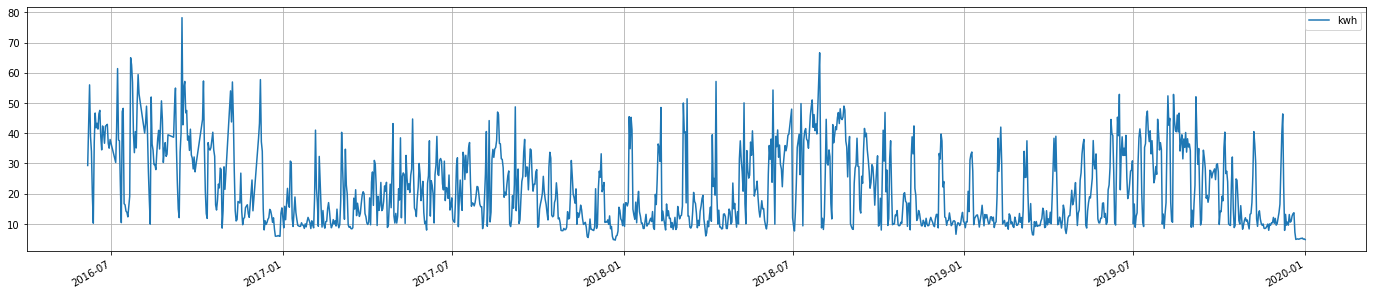

In [ ]:
# plot non-scaled kwh data
df.kwh.plot(figsize=(24,5), grid=True, legend=True);

### Scale the data

In [5]:
def scale_data(df):
    """
    Scale time series features, save the scaler function for each feature in a look up dict for inverse scaling post model training. 
    
    Parameters
    ----------
    df: pandas dataframe
    
    Returns
    -------
    df: pandas datafarme 
        Contains scaled features
        
    scaler_dict: dict 
        look up for feature scaler objects 
        key: column name
        value: column scaler 
    """
    
    # column scaler functions
    scaler_dict = {} 
    
    # scaled column data
    scaled_data = {} 
    
    for col in df.columns:
        
        # instantiate the scaler class 
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # reshape to avoid shape errors
        feat = df[col].values.reshape(-1, 1)
        
        # scale data
        col_scaled = scaler.fit_transform(feat)
        
        # dictionary with scaled data for each column
        scaled_data[col] = col_scaled.flatten()
        
        # dictionary with scaler function for each column 
        scaler_dict[col] = scaler
        
    # move scaled data from dict to dataframe
    df_scaled = pd.DataFrame.from_dict(scaled_data)
    
    return df_scaled, scaler_dict

In [6]:
# scale data 
df_scaled, scalers = scale_data(df)
df_scaled.head()

,kwh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week_y
0,0.335705,0.791045,0.785256,0.796875,0.846154,0.864865,0.852941,1.00,0.767544,0.463415,0.060606,0.139013,0.000000,0.181818,0.250000,0.250000,0.032762,0.000000
1,0.526399,0.910448,0.951923,0.984375,0.938462,0.918919,0.867647,0.78,0.527778,0.353659,0.272727,0.372197,0.352941,0.363636,0.416667,0.416667,0.000000,0.166667
2,0.697993,0.940299,0.961538,0.921875,0.892308,0.894895,0.808824,0.80,0.476608,0.256098,0.303030,0.188341,0.000000,0.363636,0.333333,0.416667,0.000000,0.333333
3,0.467702,0.865672,0.891026,0.875000,0.892308,0.909910,0.882353,0.94,0.635965,0.402439,0.303030,0.242152,0.000000,0.454545,0.500000,0.500000,0.001489,0.500000
4,0.399143,0.820896,0.842949,0.859375,0.876923,0.900901,0.867647,0.94,0.719298,0.487805,0.303030,0.291480,0.000000,0.272727,0.333333,0.416667,0.000000,0.666667


### Visualize the scaled data

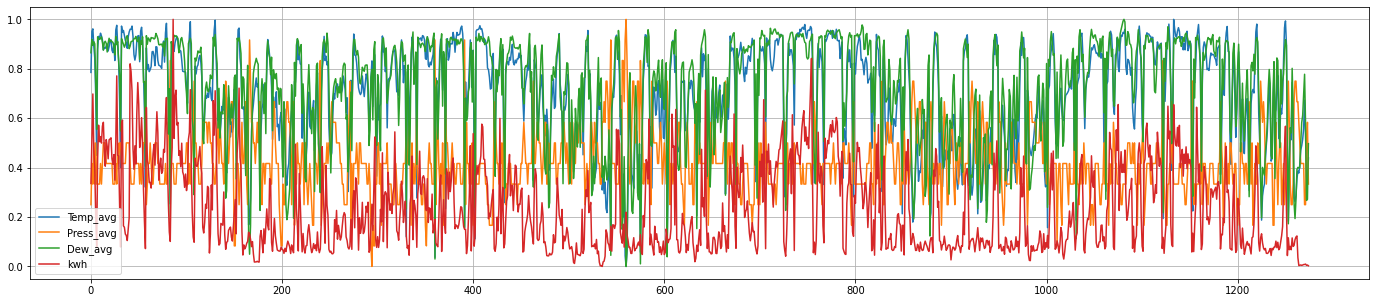

In [7]:
# plot scaled data
df_scaled.Temp_avg.plot(figsize=(24,5), grid=True, legend=True);
df_scaled.Press_avg.plot(figsize=(24,5), grid=True, legend=True);
df_scaled.Dew_avg.plot(figsize=(24,5), grid=True, legend=True);
df_scaled.kwh.plot(figsize=(24,5), grid=True, legend=True);

### Select the targets and features for our model

In [ ]:
df.head()

,kwh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week_y
2016-06-06,29.323,87,76.6,70,73,70.8,68,100,84.0,53,8,4.7,0,29.7,29.7,29.6,0.44,0
2016-06-07,43.361,95,87.0,82,79,74.4,69,89,67.6,44,15,9.9,6,29.9,29.9,29.8,0.00,1
2016-06-08,55.993,97,87.6,78,76,72.8,65,90,64.1,36,16,5.8,0,29.9,29.8,29.8,0.00,2
2016-06-09,39.040,92,83.2,75,76,73.8,70,97,75.0,48,16,7.0,0,30.0,30.0,29.9,0.02,3
2016-06-10,33.993,89,80.2,74,75,73.2,69,97,80.7,55,16,8.1,0,29.8,29.8,29.8,0.00,4


In [8]:
input_cols = ['kwh', 'Temp_avg', 'Dew_avg', 'Press_avg']
df = df[input_cols]
df.head()

,kwh,Temp_avg,Dew_avg,Press_avg
2016-06-06,29.323,76.6,70.8,29.7
2016-06-07,43.361,87.0,74.4,29.9
2016-06-08,55.993,87.6,72.8,29.8
2016-06-09,39.040,83.2,73.8,30.0
2016-06-10,33.993,80.2,73.2,29.8


In [9]:
df_save = df
df = df_scaled[input_cols]
df

,kwh,Temp_avg,Dew_avg,Press_avg
0,0.335705,0.785256,0.864865,0.250000
1,0.526399,0.951923,0.918919,0.416667
2,0.697993,0.961538,0.894895,0.333333
3,0.467702,0.891026,0.909910,0.500000
4,0.399143,0.842949,0.900901,0.333333
...,...,...,...,...
1270,0.008015,0.673077,0.777778,0.250000
1271,0.009495,0.532051,0.579580,0.250000
1272,0.004578,0.363782,0.267267,0.500000
1273,0.005868,0.339744,0.271772,0.583333


----
##5. Create samples and targets for time series forecasting
We'll create our samples and targets according to a scheme similar to that visualized below, <br>
using a continuous sequence of the `kwh` usage over the last `look_back` days <br>to forecast the `kwh` usage over the next `look_ahead` days.<br>
Note that for time series forecasting, we do *not* shuffle the data to make batches, because is essential to preserve the order of the samples.

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/11/Sliding-Window-Approach-to-Modeling-Time-Series.png)

Though we won't do cross-validation in this lesson, here is a cross-validation scheme for time-series forecasting.

![](https://i.stack.imgur.com/fXZ6k.png )

### Create sequences **X** and targets **y**
Each sequence in **X** will have `look_back` consecutive time series samples <br>before the current sample which will be used to predict a target **y** at `look_ahead` time steps after the current sample.<br>
The `create_dataset()` function assumes <br>
- the input is a `numpy` array where each column is a time series. <br>
- the first column must be the target time series
- the remaining columns are feature time series

In [14]:
def create_dataset(data, look_back=None, look_ahead=None, predict_only_last=None):
    """
    Takes a 2D array of sequential data and creates (X) input and (Y) output sequences for timeseries forecasting.
    
    Parameters
    ---------
    data: 2D numpy array
        Contains sequential data with n rows and m columns, whose first column is the targets, and other columns are features
        
        If you provide more than a single input feature, make sure that the targets are in
        the first (i.e. 0 index) column of the the array. The code below assumes this to be the case! 
        
        Example
        -------
        For the example data below, kWh column will be used as the output feature (i.e. what the model will be predicting).
        
                    kWh     Temp_avg
            0	0.335705	0.785256
            1	0.526399	0.951923
            2	0.697993	0.961538
            3	0.467702	0.891026
            4	0.399143	0.842949      
        
    look_back: int or float
        length of input sequence 
        
        I.E if look_behind = 1, then the input is a single value with index [t] (the present timestep)
            if look_behind = 2, then the input is a sequence of values with indices [t - 1, t]
            if look_behind = n, then the input is a sequence of values with indices [t - (n - 1), ... , t - 1, t]
            
    look_ahead: int or float
        number of steps into the future that we want to forecast
        
        I.E. if look_ahead = 1, then we want to forecast the value 1 timestep from now,  t + 1
             if look_ahead = 2, then we want to forecast the value 2 timesteps from now, t + 2
             if look_ahead = n, then we want to forecast the value n timesteps from now, t + n
    """
    # initialize list of input (X) and target (Y) sequence samples 
    X_data, Y_data = [], []
    
    # total number of time series samples in the original dataset
    n_samples = len(data)
    
    # number of consecutive time series samples needed to create an (input, target) sequence
    window_length = look_back + look_ahead 
    
    # number of sequences we can create from the original dataset,
    #    given the look_back & look_ahead windows 
    n_sequences = n_samples - window_length + 1
    print(f'Creating {n_sequences} X, Y samples')
    
    # get the targets
    #      if user provided data with more than a single input feature
    #           then index for the feature in the 0 index and use that as the output feature
    if data.shape[1] > 1:
        y_data = data[:, 0]
        
        # drop the target (first column) from the data array
        # it's not cheating to incorporate the kwh data in the input sample, 
        #   since we're still not using future data to predict
        #   data = data[:, 1:]

    # if user provided only a single column, then target is the same as the feature
    else:
        y_data = data

        
    # LOGIC FOR CREATING X AND Y 
    #      we are going to create n_sequences number of sequences for our model 
    for i in range(n_sequences):
        
        # create input sequence sample from the next look_back rows of the input array
        x = data[i : i+look_back]
        
        # create output sequence sample
        #      we are predicting a series of target values for look_ahead time steps in the future
        y = y_data[i+look_back : i + look_back + look_ahead ]

        # option to predict only the last time step
        # take only the last value of the sequence as our target 
        if(predict_only_last):
          y = y[-1] 
        
        # append new samples to lists
        X_data.append(x)
        Y_data.append(y)

        
    return np.array(X_data), np.array(Y_data)


### Time for a Unit Test!
`create_dataset()` does all the important work of formatting the input data for machine learning modeling. <br> Before moving on, we need to verify that it works correctly!<br><br>
This is an example of the [Test Driven Development](https://en.wikipedia.org/wiki/Test-driven_development) paradigm (TDD), an essential "best practice" for modern software development. <br>
Broadly speaking, the idea is to write code in small units with well-defined inputs and outputs, and verify each unit as you go by running tests (unsurprisingly called Unit Tests) that are designed to probe all aspects of the unit's functionality.<br>

For our Unit Tests, we'll create small, simple _dummy_ input data sets to pass in to `create_dataset()`.<br>Then we'll check whether the resulting outputs `X_data` and `Y_data` are what we expect.



In [ ]:
# create dummy array to test how function works
# note: the values here are completely arbitrary
# but using small, sequential integers helps us understanding how the sequences are structured
n = 11
repetitions = 4
dummy_data = np.arange(1, n)
print(dummy_data.shape)
dummy_data = dummy_data[:,None]
print(dummy_data.shape)
print(dummy_data)
dummy_data = np.tile(dummy_data, (1, repetitions))
print(dummy_data.shape)
print(f'input data\n {dummy_data}')

(10,)
(10, 1)
[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
(10, 4)
input data
 [[ 1  1  1  1]
 [ 2  2  2  2]
 [ 3  3  3  3]
 [ 4  4  4  4]
 [ 5  5  5  5]
 [ 6  6  6  6]
 [ 7  7  7  7]
 [ 8  8  8  8]
 [ 9  9  9  9]
 [10 10 10 10]]


In [ ]:
X_data, Y_data = create_dataset(dummy_data, look_back=2, look_ahead=1, predict_only_last=True)
print(X_data.shape)
print(f'input sequences \n {X_data}')
print(f'targets\n {Y_data[:,None]}')

Creating 8 X, Y samples
(8, 2, 4)
input sequences 
 [[[1 1 1 1]
  [2 2 2 2]]

 [[2 2 2 2]
  [3 3 3 3]]

 [[3 3 3 3]
  [4 4 4 4]]

 [[4 4 4 4]
  [5 5 5 5]]

 [[5 5 5 5]
  [6 6 6 6]]

 [[6 6 6 6]
  [7 7 7 7]]

 [[7 7 7 7]
  [8 8 8 8]]

 [[8 8 8 8]
  [9 9 9 9]]]
targets
 [[ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]


What about if the input data set is only a single time series?

In [ ]:
input_data = dummy_data[:,0][:,None]
X_data, Y_data = create_dataset(input_data, look_back=3, look_ahead=2, predict_only_last=False)
print(X_data.shape)
print(f'X_data (input sequences) \n {X_data}')
print(f'Y_data (target sequences) \n {Y_data}')

Creating 6 X, Y samples
(6, 3, 1)
X_data (input sequences) 
 [[[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]

 [[3]
  [4]
  [5]]

 [[4]
  [5]
  [6]]

 [[5]
  [6]
  [7]]

 [[6]
  [7]
  [8]]]
Y_data (target sequences) 
 [[[ 4]
  [ 5]]

 [[ 5]
  [ 6]]

 [[ 6]
  [ 7]]

 [[ 7]
  [ 8]]

 [[ 8]
  [ 9]]

 [[ 9]
  [10]]]


What about the case when you want to predict *all* the `look_ahead` data points and not just the last one?

In [ ]:
X_data, Y_data = create_dataset(dummy_data, look_back=2, look_ahead=2, predict_only_last=False)
print(X_data.shape)
print(f'output sequences \n {X_data}')
print(f'targets\n {Y_data[:,None]}')

Creating 7 X, Y samples
(7, 2, 4)
output sequences 
 [[[1 1 1 1]
  [2 2 2 2]]

 [[2 2 2 2]
  [3 3 3 3]]

 [[3 3 3 3]
  [4 4 4 4]]

 [[4 4 4 4]
  [5 5 5 5]]

 [[5 5 5 5]
  [6 6 6 6]]

 [[6 6 6 6]
  [7 7 7 7]]

 [[7 7 7 7]
  [8 8 8 8]]]
targets
 [[[ 3  4]]

 [[ 4  5]]

 [[ 5  6]]

 [[ 6  7]]

 [[ 7  8]]

 [[ 8  9]]

 [[ 9 10]]]


We can see from the above results that `create_dataset()` does its job on all counts! <br>
Achievement unlocked -- Unit Tests passed!<br>
Now move on to the next task...

### Create the data set for our forecasting problem

In [13]:
def create_train_test_split(df, look_back = None, look_ahead = None, train_size = 0.70, predict_only_last=None):
    """
    Creates a train test split for sequential data used for time series forecasting. 
    """
    
    # calculate the number of training samples 
    n_samples = df.shape[0]
    train_size = int(n_samples * train_size)

    # consecutive samples indexed from zero up to but not including train_size are the training samples 
    train = df.iloc[:train_size].values
    
    # consecutive samples indexed from train_size up to the end are the test samples 
    test = df.iloc[train_size:].values

    # create input and output splits 
    X_train, Y_train = create_dataset(train, look_back=look_back, look_ahead=look_ahead, predict_only_last=predict_only_last)
    X_test, Y_test = create_dataset(test, look_back=look_back, look_ahead=look_ahead, predict_only_last=predict_only_last)
    
    return X_train, Y_train, X_test, Y_test

Number of feature columns to use in our model

In [15]:
# account for the case where we use the same time series for both feature and target
#      and for the case where we include kwh in features
n_input_cols = len(input_cols)
if n_input_cols == 1:
  n_feats =  1
elif 'kwh' in input_cols:
  n_feats = n_input_cols
else: #check this, may be wrong
  n_feats =  n_input_cols - 1
print(f'there are {n_feats} input features in our model')

there are 4 input features in our model


In [16]:
# split data into X and Y train/test sets 
look_back = 28
look_ahead = 7
predict_only_last = False

X_train, y_train, X_test, y_test = create_train_test_split(df, look_back, look_ahead, train_size=0.7, predict_only_last=predict_only_last)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


Creating 858 X, Y samples
Creating 349 X, Y samples
(858, 28, 4) (858, 7)
(349, 28, 4) (349, 7)


In [ ]:
X_train[0]

array([[0.33570467, 0.78525641, 0.86486486, 0.25      ],
       [0.52639872, 0.95192308, 0.91891892, 0.41666667],
       [0.69799349, 0.96153846, 0.89489489, 0.33333333],
       [0.46770169, 0.89102564, 0.90990991, 0.5       ],
       [0.39914257, 0.84294872, 0.9009009 , 0.33333333],
       [0.20224057, 0.69070513, 0.74474474, 0.5       ],
       [0.07657376, 0.45032051, 0.55405405, 0.33333333],
       [0.4381562 , 0.87980769, 0.92942943, 0.33333333],
       [0.5715388 , 0.93108974, 0.92192192, 0.33333333],
       [0.50492221, 0.92307692, 0.91891892, 0.33333333],
       [0.52546142, 0.94391026, 0.92192192, 0.41666667],
       [0.49923046, 0.93269231, 0.92942943, 0.33333333],
       [0.56781674, 0.91666667, 0.90840841, 0.41666667],
       [0.58342491, 0.87660256, 0.87537538, 0.5       ],
       [0.46579991, 0.88621795, 0.90690691, 0.5       ],
       [0.40582596, 0.88301282, 0.91141141, 0.5       ],
       [0.51335796, 0.89102564, 0.9024024 , 0.41666667],
       [0.48623044, 0.90064103,

In [ ]:
y_train[0]

array([0.44997439, 0.44721681, 0.24632108, 0.07874722, 0.57800484,
       0.59245836, 0.16417783])

In [ ]:
.6*1275


765.0

----
##6. Create, train, and run the time series forecasting model

In [19]:
# this model architecture is arbitrary - you can experiment with different architectures to see how it affects the score (i.e. gridsearch)

# set hyperparameter values
epochs = 25
batch_size = 32
dropout_prob = 0.5

# input shape is look_back rows by n_feats columns, for each element of the batch
input_shape = (look_back, n_feats)

# set learning rate and optimizer
opt = optimizers.Nadam(learning_rate=0.01)

# Create and train model here
model = Sequential()

# single LSTM layer
model.add(LSTM(256, input_shape=input_shape, activation='tanh', return_sequences=False))

# add dropout regularization
model.add(Dropout(dropout_prob))

# output layer WE'RE DOING REGRESSION, we want to predict continuous data
model.add(Dense(look_ahead, activation='relu'))

# compile model
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               267264    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 269,063
Trainable params: 269,063
Non-trainable params: 0
_________________________________________________________________


###Train model

Use learning rate schedule to determine a good learning rate

In [ ]:
lr_schedule = LearningRateScheduler(
     lambda epoch: 1e-4* 10**(epoch/10))
schedule_results = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=batch_size, 
                    verbose=1,
                    callbacks = [lr_schedule])

Epoch 1/40
23/23 [==============================] - 5s 6ms/step - loss: 0.0569 - mean_absolute_error: 0.1819 - lr: 1.0000e-04
Epoch 2/40
23/23 [==============================] - 0s 6ms/step - loss: 0.0435 - mean_absolute_error: 0.1629 - lr: 1.2589e-04
Epoch 3/40
23/23 [==============================] - 0s 5ms/step - loss: 0.0336 - mean_absolute_error: 0.1448 - lr: 1.5849e-04
Epoch 4/40
23/23 [==============================] - 0s 5ms/step - loss: 0.0294 - mean_absolute_error: 0.1349 - lr: 1.9953e-04
Epoch 5/40
23/23 [==============================] - 0s 5ms/step - loss: 0.0284 - mean_absolute_error: 0.1308 - lr: 2.5119e-04
Epoch 6/40
23/23 [==============================] - 0s 5ms/step - loss: 0.0272 - mean_absolute_error: 0.1268 - lr: 3.1623e-04
Epoch 7/40
23/23 [==============================] - 0s 5ms/step - loss: 0.0270 - mean_absolute_error: 0.1270 - lr: 3.9811e-04
Epoch 8/40
23/23 [==============================] - 0s 5ms/step - loss: 0.0265 - mean_absolute_error: 0.1254 - lr: 5.0

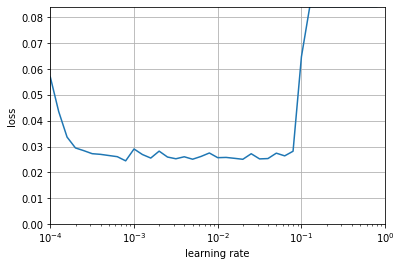

In [ ]:
plt.semilogx(schedule_results.history["lr"], schedule_results.history["loss"])
plt.axis([1e-4, 1e-0, 0, np.max(schedule_results.history["loss"])])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.grid()

Build the model again -- use learning rate of 1e-3

In [20]:
# this model architecture is arbitrary - you can experiment with different architectures to see how it affects the score (i.e. gridsearch)
epochs = 25
batch_size = 32
dropout_prob = 0.5
learning_rate = 1.e-3

# input shape is look_back rows by n_feats columns, for each element of the batch
input_shape = (look_back, n_feats)

# set learning rate and optimizer
opt = optimizers.Nadam(learning_rate=learning_rate)

# Create and train model here
model = Sequential()

model.add(LSTM(256, input_shape=input_shape, activation='tanh', return_sequences=False))

# add dropout regularization
model.add(Dropout(dropout_prob))

# output layer WE'RE DOING REGRESSION, we want to predict one kwh value for each look-ahead day
model.add(Dense(look_ahead))

# compile model

model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta=1.e-6)
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(X_test, y_test),
                    callbacks = [early_stopping])

Epoch 1/100
27/27 [==============================] - 5s 22ms/step - loss: 0.0338 - mean_absolute_error: 0.1441 - val_loss: 0.0231 - val_mean_absolute_error: 0.1299
Epoch 2/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0282 - mean_absolute_error: 0.1315 - val_loss: 0.0233 - val_mean_absolute_error: 0.1150
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0267 - mean_absolute_error: 0.1282 - val_loss: 0.0205 - val_mean_absolute_error: 0.1181
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0254 - mean_absolute_error: 0.1237 - val_loss: 0.0202 - val_mean_absolute_error: 0.1158
Epoch 5/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0243 - mean_absolute_error: 0.1215 - val_loss: 0.0235 - val_mean_absolute_error: 0.1105
Epoch 6/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0241 - mean_absolute_error: 0.1200 - val_loss: 0.0192 - val_mean_absolute_error: 0.1111
Epoch 7/100
27/27 [==

---
### Visualize training results

In [22]:
def plot_model_loss_metrics(history):
    """
    Use the model history callback to plot the train and test losses vs epochs as well as metrics vs. epochs 
    """
    
    # plot training and test loss scores 
    test_loss = history.history["val_loss"]
    train_loss = history.history["loss"]
    
    test_mae = history.history["val_mean_absolute_error"]
    train_mae = history.history["mean_absolute_error"]
    
    n_epochs = len(test_loss) + 1
    epochs = np.arange(1,  n_epochs)
    y_ticks = np.arange(0, 1, 11)

    plt.figure(figsize=(20,5))
    plt.title("Loss vs. Number of Epochs")
    plt.plot(epochs[1:], test_loss[1:], label = "Test Loss")
    plt.plot(epochs[1:], train_loss[1:], label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epochs[1:])
    plt.grid()
    plt.legend()
    plt.show() 
    
    plt.figure(figsize=(20,5))
    plt.title("mean_absolute_error vs. Number of Epochs")
    plt.plot(epochs[1:], test_mae[1:], label = "Test MAE")
    plt.plot(epochs[1:], train_mae[1:], label = "Train MAE")
    plt.xlim(1,20)
    plt.xticks(epochs[1:])
    plt.grid()
    plt.legend()
    plt.show() 

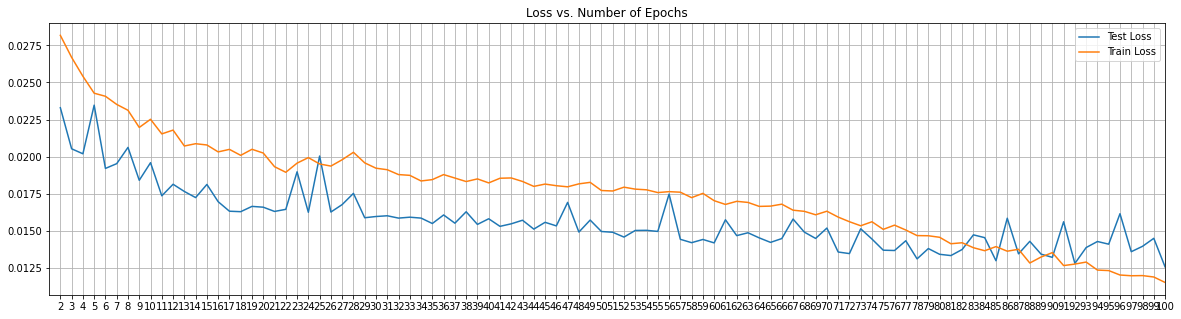

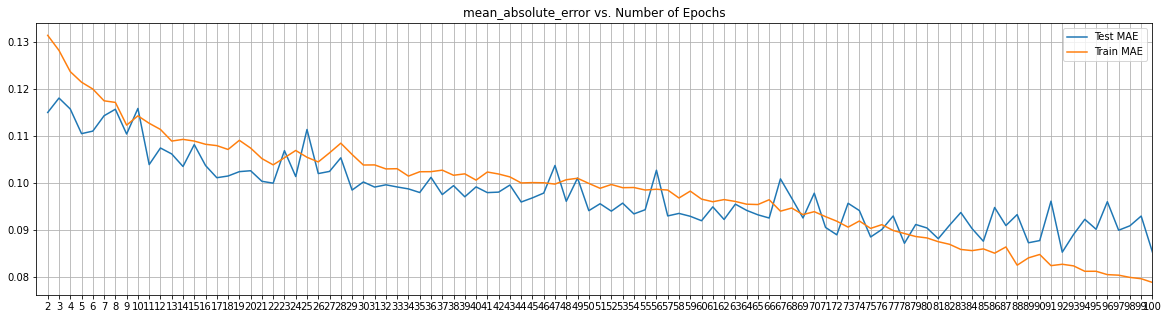

In [23]:
# plot model scores
plot_model_loss_metrics(history)

Fractional error in forecast is MAE/mean()kwh

In [35]:
kwh = X_train[:,0]
np.mean(kwh)

0.5359172800400969

In [36]:
.09/.5

0.18

### Make time series forecasts for training and test sets

In [24]:
# get predictions 
def predict(X_train, X_test):
    # make predictions on train and test inputs 
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    return y_train_predict, y_test_predict

y_train_predict, y_test_predict = predict(X_train, X_test)

In [26]:
print(y_train_predict.shape)
print(y_test_predict.shape)

(858, 7)
(349, 7)


In [27]:
# reshape Y_train and Y_test so number of rows appears first, i.e. (rows,cols)
if(predict_only_last):
  y_train = y_train.reshape(y_train.shape[0], 1)
  y_test = y_test.reshape(y_test.shape[0], 1)

In [28]:
# transform data back to original scale
def inverse_scaling(data, scaler_dict, output_feat_name):
    """
    Now that we have trained our model on scaled data (and made predictions on the scaled test data)
    we need to invert the scaling for interpretability. 
    """
    return scaler_dict[output_feat_name].inverse_transform(data)

# undo the normalization to get targets in kwh
y_train = inverse_scaling(y_train, scalers, 'kwh')
y_test = inverse_scaling(y_test, scalers, 'kwh')

# undo the normalization to get predictions in kwh
y_train_predict = inverse_scaling(y_train_predict, scalers, 'kwh')
y_test_predict = inverse_scaling(y_test_predict, scalers, 'kwh')

----
### Plot Model Predictions

In [29]:
def plot_predictions(Y_train, y_train_predict, Y_test, y_test_predict):
    
    plt.figure(figsize=(20,5))
    plt.title("Training Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_train_predict[:,0], label = "Predict", c="r")
    plt.plot(Y_train[:,0], label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();
    
    plt.figure(figsize=(20,5))
    plt.title("Test Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_test_predict[:,0], label = "Predict", c="r")
    plt.plot(Y_test[:,0], label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();

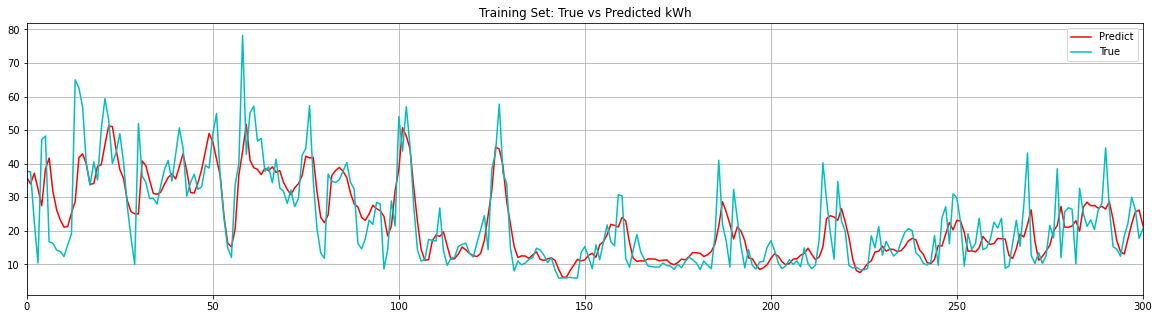

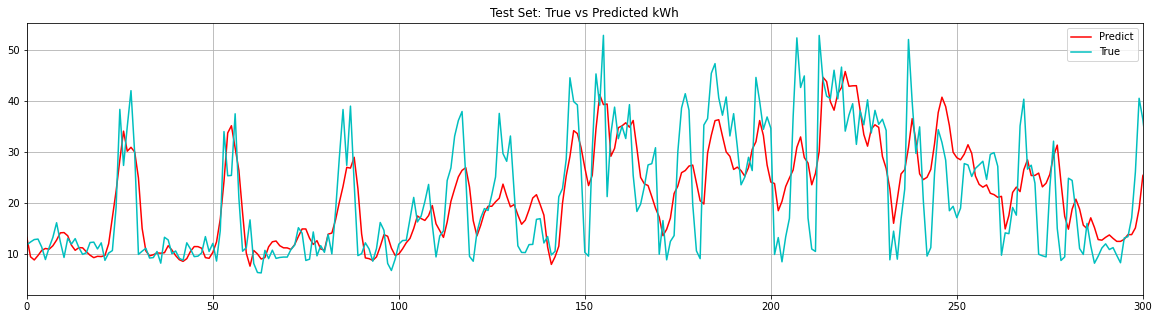

In [30]:
# plot model predictions 
plot_predictions(y_train, y_train_predict, y_test, y_test_predict)

-----
### Compare Model against a Naive Baseline 

A naive model might predict that the power consumption tomorrow (or `look_ahead` days from now) will be the same as today's value. The error in this baseline model is the Root-Mean-Squared difference between the time series of kWh with the time series of kWh shifted forward by `look_ahead` days.

So then we can ask the question "can our fancy LSTM model perform better than a naive model of simply assuming that the kwh power consumption tomorrow (or `look_ahead` days from now) will be the same as it is today?"

The naive model is pretty bad -- 30% to 100% error.<br>
However, we find that our LSTM model does outperform the naive model!

In [31]:
# use RMSE (root mean squared error) as metric to compare test scores with baseline model

# RMSE for forecasting all the look_ahead days

# test_scores
print(f'Scores when forecasting with our LSTM model on the test data:')
for day  in range(look_ahead):
  test_score_ = math.sqrt(mean_squared_error(y_test[:,day], y_test_predict[:,day],))
  print(f'RMSE = {test_score_:.2f} kwh for forecasting {day+1} day(s) in the future')
test_score_all = math.sqrt(mean_squared_error(y_test, y_test_predict))
print(f'Mean RMSE = {test_score_all:.2f} kwh for forecasting all {look_ahead} look_ahead days in the future')

# naive scores i.e. assuming that future kwh consumption will be the same as today for look_ahead days in the future
print(f'\nCompare with naive baseline scores:')
for day in range(1, look_ahead+1):
  y1 = [y_test[i][0] for i in range(0,len(y_test) - day)]
  y2 = [y_test[j][0] for j in range(day,len(y_test))]
  naive_score = math.sqrt(mean_squared_error(y1,y2))
  print(f'RMSE = {naive_score:.2f} kwh for forecasting {day} day(s) in the future') 

Scores when forecasting with our LSTM model on the test data:
RMSE = 7.25 kwh for forecasting 1 day(s) in the future
RMSE = 8.32 kwh for forecasting 2 day(s) in the future
RMSE = 8.47 kwh for forecasting 3 day(s) in the future
RMSE = 8.34 kwh for forecasting 4 day(s) in the future
RMSE = 8.28 kwh for forecasting 5 day(s) in the future
RMSE = 8.38 kwh for forecasting 6 day(s) in the future
RMSE = 8.64 kwh for forecasting 7 day(s) in the future
Mean RMSE = 8.25 kwh for forecasting all 7 look_ahead days in the future

Compare with naive baseline scores:
RMSE = 8.07 kwh for forecasting 1 day(s) in the future
RMSE = 11.40 kwh for forecasting 2 day(s) in the future
RMSE = 13.57 kwh for forecasting 3 day(s) in the future
RMSE = 14.64 kwh for forecasting 4 day(s) in the future
RMSE = 15.01 kwh for forecasting 5 day(s) in the future
RMSE = 14.44 kwh for forecasting 6 day(s) in the future
RMSE = 13.72 kwh for forecasting 7 day(s) in the future


### References:
* For more on timeseries forecasting, see this resource: [Awesome AI 2021](https://docs.google.com/document/d/1IE08t5ZfSw3MOuIjNPlo8Sc5USr4KXrR/edit?usp=sharing&ouid=118082286684790035002&rtpof=true&sd=true)

